In [1]:
# Colab setup: install required packages
!pip install yfinance newsapi-python vaderSentiment nltk --quiet

# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
import os
import json
import time
from datetime import datetime, timedelta
from typing import List, Dict, Any, Tuple

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Colab-friendly display
pd.set_option('display.max_colwidth', 200)

# Config - set to True if you provide a NewsAPI key below
USE_NEWSAPI = True

# Paste your NewsAPI key here (if USE_NEWSAPI True)
NEWSAPI_KEY = "86434399471c42f0a1715851025b323e"

# Memory file path (keeps minimal notes across runs)
MEMORY_PATH = "/content/agent_memory.json"

# Ensure memory file exists
if not os.path.exists(MEMORY_PATH):
    with open(MEMORY_PATH, "w") as f:
        json.dump({}, f)


In [3]:
def load_memory() -> Dict[str, Any]:
    with open(MEMORY_PATH, "r") as f:
        try:
            return json.load(f)
        except json.JSONDecodeError:
            return {}

def save_memory(mem: Dict[str, Any]) -> None:
    with open(MEMORY_PATH, "w") as f:
        json.dump(mem, f, indent=2)

def append_memory(ticker: str, entry: Dict[str, Any]) -> None:
    mem = load_memory()
    symbol_memory = mem.get(ticker.upper(), [])
    symbol_memory.append(entry)
    mem[ticker.upper()] = symbol_memory[-10:]  # keep last 10 entries
    save_memory(mem)

def now_str() -> str:
    return datetime.utcnow().isoformat() + "Z"


In [4]:
# Price fetcher using yfinance
def fetch_price_data(ticker: str, period: str = "1y", interval: str = "1d") -> pd.DataFrame:
    ticker_obj = yf.Ticker(ticker)
    hist = ticker_obj.history(period=period, interval=interval, actions=False)
    hist.reset_index(inplace=True)
    return hist

# News fetcher using NewsAPI (or mocked fallback)
def fetch_news(ticker: str, days: int = 7, max_results: int = 20) -> List[Dict[str, Any]]:
    if not USE_NEWSAPI or NEWSAPI_KEY in (None, "", "PASTE_YOUR_NEWSAPI_KEY_HERE"):
        # Fallback: return a mocked sample news list if user didn't set an API key
        mocked = [{
            "title": f"Sample news headline for {ticker}",
            "description": f"{ticker} posts strong quarter, analysts react positively.",
            "publishedAt": now_str(),
            "source": {"name": "MockNews"}
        }]
        return mocked

    newsapi = NewsApiClient(api_key=NEWSAPI_KEY)
    #from_date = (datetime.utcnow() - timedelta(days=days)).strftime("%Y-%m-%d")
    from datetime import timezone
    from_date = (datetime.now(timezone.utc) - timedelta(days=days)).strftime("%Y-%m-%d")

    q = f"{ticker} OR \"{ticker}\" OR {ticker} stock"
    try:
        res = newsapi.get_everything(q=q, from_param=from_date, language='en', sort_by='relevancy', page_size=max_results)
        articles = res.get("articles", [])
        return articles
    except Exception as e:
        print("NewsAPI fetch error:", e)
        return []


In [5]:
stop_words = set(stopwords.words('english'))
sentiment_analyzer = SentimentIntensityAnalyzer()

def preprocess_text(text: str) -> str:
    if not text:
        return ""
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t.lower() for t in tokens if t.lower() not in stop_words]
    return " ".join(tokens)

def classify_article(article: Dict[str, Any]) -> str:
    # Simple heuristic classification: earnings, product, macro, other
    text = " ".join(filter(None, [article.get("title",""), article.get("description","")]))
    lc = text.lower()
    if any(w in lc for w in ["earn", "quarter", "q1", "q2", "q3", "q4", "eps", "revenue"]):
        return "earnings"
    if any(w in lc for w in ["product", "launch", "release", "announc"]):
        return "product"
    if any(w in lc for w in ["inflation", "fed", "interest rate", "gdp", "unemployment"]):
        return "macro"
    return "other"

def extract_metrics(article: Dict[str, Any]) -> Dict[str, Any]:
    # Extract sentiment + simple keyword highlights
    text = " ".join(filter(None, [article.get("title",""), article.get("description","")]))
    sentiment = sentiment_analyzer.polarity_scores(text)
    preproc = preprocess_text(text)
    top_tokens = list(dict.fromkeys(preproc.split()))[:10]  # unique tokens, limited
    return {"sentiment": sentiment, "keywords": top_tokens, "raw_text": text}


In [6]:
# Base Agent class (lightweight)
class Agent:
    def __init__(self, name: str):
        self.name = name

    def act(self, *args, **kwargs):
        raise NotImplementedError

# Specialist agents
class PriceAgent(Agent):
    def act(self, ticker: str) -> Dict[str, Any]:
        df = fetch_price_data(ticker)
        latest = df.iloc[-1].to_dict() if not df.empty else {}
        # compute simple indicators
        df['return_30d'] = df['Close'].pct_change(30)
        summary = {
            "ticker": ticker.upper(),
            "last_price": latest.get("Close"),
            "last_date": latest.get("Date").isoformat() if latest.get("Date") is not None else None,
            "history_len": len(df)
        }
        return {"type": "price", "data": summary, "df": df}

class NewsAgent(Agent):
    def act(self, ticker: str) -> Dict[str, Any]:
        articles = fetch_news(ticker, days=14, max_results=30)
        processed = []
        for a in articles:
            cls = classify_article(a)
            extr = extract_metrics(a)
            processed.append({"article": a, "class": cls, "extracted": extr})
        return {"type": "news", "data": processed}

class FinancialsAgent(Agent):
    def act(self, ticker: str) -> Dict[str, Any]:
        # Use yfinance to fetch basic financials
        t = yf.Ticker(ticker)
        info = t.info
        fin = {
            "marketCap": info.get("marketCap"),
            "trailingPE": info.get("trailingPE"),
            "forwardPE": info.get("forwardPE"),
            "dividendYield": info.get("dividendYield"),
            "beta": info.get("beta")
        }
        return {"type": "financials", "data": fin}

class EvaluatorAgent(Agent):
    def act(self, analysis: Dict[str, Any]) -> Dict[str, Any]:
        # Basic evaluator - checks for missing pieces and rates confidence
        score = 100
        notes = []
        # require price + news + financials present
        if 'price' not in analysis:
            score -= 40
            notes.append("Missing price data")
        if 'news' not in analysis:
            score -= 30
            notes.append("Missing news analysis")
        if 'financials' not in analysis:
            score -= 20
            notes.append("Missing financials")
        # check sentiment balance
        neg = 0
        pos = 0
        news = analysis.get('news', [])
        for n in news:
            s = n['extracted']['sentiment']
            if s['compound'] >= 0.05:
                pos += 1
            elif s['compound'] <= -0.05:
                neg += 1
        if pos + neg > 0:
            if pos > neg:
                notes.append("News sentiment leans positive")
            elif neg > pos:
                notes.append("News sentiment leans negative")
            else:
                notes.append("News sentiment mixed")
        else:
            notes.append("No sentiment signals")
        return {"score": score, "notes": notes}

class OptimizerAgent(Agent):
    def act(self, draft: str, feedback: Dict[str, Any]) -> str:
        # Simple optimizer: append evaluator notes and minor edits
        enhanced = draft.strip()
        enhanced += "\n\n[Evaluator Notes]\n"
        for n in feedback.get('notes', []):
            enhanced += "- " + n + "\n"
        enhanced += f"\nConfidence Score: {feedback.get('score', 0)}/100\n"
        return enhanced


In [7]:
class InvestmentResearchAgent(Agent):
    def __init__(self, name: str):
        super().__init__(name)
        # instantiate specialists
        self.price_agent = PriceAgent("PriceAgent")
        self.news_agent = NewsAgent("NewsAgent")
        self.fin_agent = FinancialsAgent("FinancialsAgent")
        self.evaluator = EvaluatorAgent("EvaluatorAgent")
        self.optimizer = OptimizerAgent("OptimizerAgent")

    def plan(self, ticker: str) -> List[str]:
        # A simple planning routine that decides steps
        plan_steps = [
            "fetch_price",
            "fetch_financials",
            "fetch_news",
            "analyze_news",
            "compose_draft",
            "evaluate",
            "optimize",
            "store_memory"
        ]
        return plan_steps

    def route_and_run(self, ticker: str) -> Dict[str, Any]:
        ticker = ticker.upper()
        steps = self.plan(ticker)
        results = {}
        # routing
        if "fetch_price" in steps:
            results['price'] = self.price_agent.act(ticker)
        if "fetch_financials" in steps:
            results['financials'] = self.fin_agent.act(ticker)
        if "fetch_news" in steps:
            results['news'] = self.news_agent.act(ticker)['data']
        # compose draft
        results['draft'] = self.compose_draft(ticker, results)
        # evaluate
        eval_out = self.evaluator.act({
            "price": results.get('price'),
            "financials": results.get('financials'),
            "news": results.get('news')
        })
        results['evaluation'] = eval_out
        # optimize (refine)
        results['final_report'] = self.optimizer.act(results['draft'], eval_out)
        # store memory
        mem_entry = {
            "timestamp": now_str(),
            "summary": results['final_report'][:500],  # store partial summary
            "evaluation": eval_out
        }
        append_memory(ticker, mem_entry)
        results['memory_saved'] = True
        return results

    def compose_draft(self, ticker: str, results: Dict[str, Any]) -> str:
        # Compose a human-readable analysis based on gathered data
        lines = []
        lines.append(f"Investment Research Draft for {ticker}\nGenerated: {now_str()}\n")
        price = results.get('price', {}).get('data', {})
        if price:
            lines.append(f"Latest price: {price.get('last_price')} (as of {price.get('last_date')})\n")
        fin = results.get('financials', {}).get('data', {})
        if fin:
            lines.append("Key Financials:\n")
            for k, v in fin.items():
                lines.append(f"- {k}: {v}\n")
        news = results.get('news', [])
        if news:
            lines.append("\nRecent News Highlights:\n")
            # summarize top 3 by recency and absolute sentiment score
            scored = []
            for n in news:
                s = n['extracted']['sentiment']
                scored.append((abs(s['compound']), n))
            scored_sorted = sorted(scored, key=lambda x: x[0], reverse=True)[:5]
            for score, n in scored_sorted:
                t = n['article'].get('title')
                s_comp = n['extracted']['sentiment']['compound']
                cls = n['class']
                lines.append(f"- [{cls}] {t} (sentiment={s_comp})\n")
        # draft conclusion heuristics
        pos = sum(1 for n in news if n['extracted']['sentiment']['compound'] >= 0.05)
        neg = sum(1 for n in news if n['extracted']['sentiment']['compound'] <= -0.05)
        conclusion = "Neutral"
        if pos > neg and pos >= max(1, neg):
            conclusion = "Cautiously Positive"
        elif neg > pos and neg >= max(1, pos):
            conclusion = "Cautiously Negative"
        lines.append(f"\nPreliminary conclusion: {conclusion}\n")
        return "\n".join(lines)


In [8]:
def run_analysis(ticker: str) -> Dict[str, Any]:
    ira = InvestmentResearchAgent("InvestmentResearchAgent")
    results = ira.route_and_run(ticker)
    return results

def plot_price_df(df: pd.DataFrame, ticker: str):
    if df is None or df.empty:
        print("No price data to plot.")
        return
    plt.figure(figsize=(10, 4))
    plt.plot(df['Date'], df['Close'])
    plt.title(f"{ticker} Close Price")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Running full analysis for AAPL ...


/tmp/ipython-input-2553058485.py:20: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().isoformat() + "Z"



--- FINAL REPORT ---

Investment Research Draft for AAPL
Generated: 2025-10-10T13:04:05.149016Z

Latest price: 254.0399932861328 (as of 2025-10-09T00:00:00-04:00)

Key Financials:

- marketCap: 3770052509696

- trailingPE: 38.607903

- forwardPE: 30.570395

- dividendYield: 0.41

- beta: 1.094


Recent News Highlights:

- [other] Save 25 Percent on This Sonos Prime Day Soundbar Deal (sentiment=0.926)

- [other] The only Prime Day smartwatch deal you should care about is selling out fast — it won't last long! (sentiment=0.8748)

- [other] Apple Inc. (AAPL) Sued Over Workplace Discrimination (sentiment=0.7906)

- [other] Plug Power stock surges on good news on green hydrogen (sentiment=0.7906)

- [other] Are You Looking for a High-Growth Dividend Stock? (sentiment=0.787)


Preliminary conclusion: Cautiously Positive

[Evaluator Notes]
- News sentiment leans positive

Confidence Score: 100/100


--- EVALUATION ---
{'score': 100, 'notes': ['News sentiment leans positive']}

Memory entries

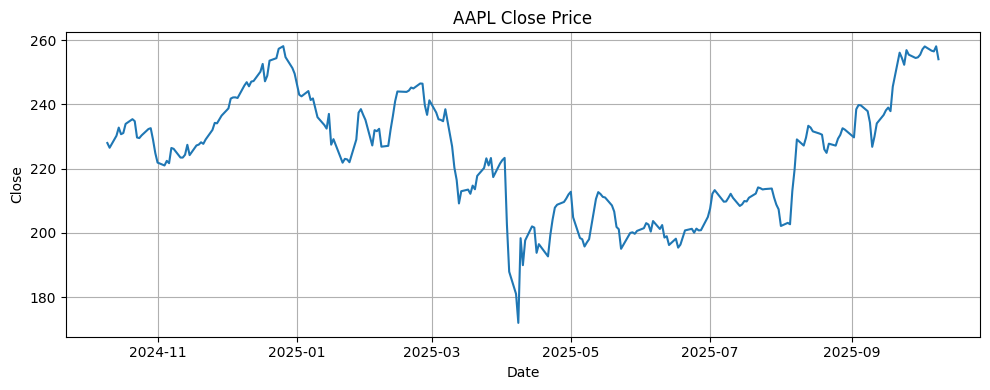


Running full analysis for TSLA ...


/tmp/ipython-input-2553058485.py:20: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().isoformat() + "Z"



--- FINAL REPORT ---

Investment Research Draft for TSLA
Generated: 2025-10-10T13:04:06.019253Z

Latest price: 435.5400085449219 (as of 2025-10-09T00:00:00-04:00)

Key Financials:

- marketCap: 1448236285952

- trailingPE: 256.2

- forwardPE: 134.42593

- dividendYield: None

- beta: 2.086


Recent News Highlights:

- [other] Gets Sell Rating as EV Tax Credits in U.S. Expire (sentiment=0.8777)

- [earnings] TSLA Crashes 10% AGAIN—But $70¢ Earnings & FSD 14 and $35K Model to the Rescue (sentiment=0.8767)

- [other] The only Prime Day smartwatch deal you should care about is selling out fast — it won't last long! (sentiment=0.8748)

- [other] Are You Looking for a High-Growth Dividend Stock? (sentiment=0.787)

- [other] Tesla Inc. (TSLA) Receives EV Sales Boost in Europe in September (sentiment=0.7845)


Preliminary conclusion: Cautiously Positive

[Evaluator Notes]
- News sentiment leans positive

Confidence Score: 100/100


--- EVALUATION ---
{'score': 100, 'notes': ['News sentiment l

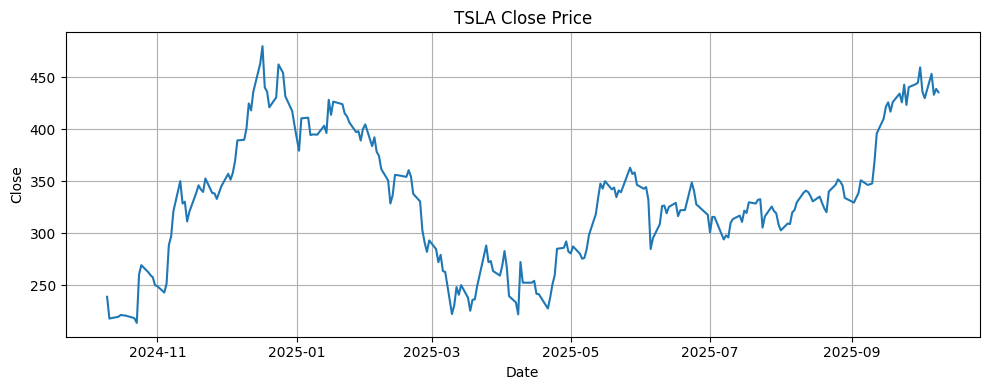

In [9]:
# Example run for AAPL and TSLA. You can replace with any symbol (e.g., AMZN, MSFT).
sample_tickers = ["AAPL", "TSLA"]

for t in sample_tickers:
    print("\n" + "="*60)
    print(f"Running full analysis for {t} ...")
    results = run_analysis(t)
    # Print summary report
    print("\n--- FINAL REPORT ---\n")
    print(results['final_report'])
    print("\n--- EVALUATION ---")
    print(results['evaluation'])
    # show memory stored
    mem = load_memory()
    print(f"\nMemory entries for {t}: {len(mem.get(t, []))}")
    # plot price history if available
    df = results['price']['df']
    plot_price_df(df, t)
